 # Text Classification with RNN / LSTM / GRU Using Reuters Dataset

In this exercise, you will build and compare text classification models using the Reuters newswire dataset, a well-known benchmark for multi-class topic classification. You will learn how to preprocess text data, represent it using embeddings, and train recurrent neural networks - including Simple RNN, LSTM, and GRU - to identify news topics automatically.

By completing this notebook, you will gain practical experience in:

Preparing textual data for deep learning models.

Understanding the differences between RNN, LSTM, and GRU architectures.

Evaluating and visualizing model performance on real-world data.

This exercise helps develop intuition for how recurrent models capture sequential patterns in language and how architectural choices affect accuracy and generalization.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)

# 1. Load Reuters dataset
The Reuters dataset contains newswire topics classification (46 classes). We keep only the top 'num_words' most frequent words, and cut sequences to 'maxlen' tokens.

In [2]:
num_words = 5000
maxlen = 100

(x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(num_words=num_words)

# Pad sequences to ensure they all have the same length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test  = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# Split off a validation set (first 1000 samples)
x_val, y_val = x_train[:1000], y_train[:1000]
x_train, y_train = x_train[1000:], y_train[1000:]

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

# Number of output classes
num_classes = max(y_train) + 1
print("Num classes:", num_classes)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
Train: (7982, 100) Val: (1000, 100) Test: (2246, 100)
Num classes: 46


# 2. Build model function

In [3]:
def build_model(cell_type="RNN", units=32, vocab_size=5000, maxlen=100, num_classes=46):
    """
    Builds a simple text classification model using RNN, LSTM, or GRU.

    Args:
        cell_type (str): "RNN", "LSTM", or "GRU"
        units (int): Number of hidden units for the recurrent layer
        vocab_size (int): Vocabulary size for the Embedding layer
        maxlen (int): Maximum sequence length
        num_classes (int): Number of output classes (Reuters has 46)

    Returns:
        Compiled Keras model
    """

    # Input layer for padded sequences
    inputs = keras.Input(shape=(maxlen,))

    # Embedding layer: turns integer word indices into dense vectors
    x = layers.Embedding(input_dim=vocab_size, output_dim=64)(inputs)

    # Choose the recurrent layer
    if cell_type == "RNN":
        x = layers.SimpleRNN(units)(x)
    elif cell_type == "LSTM":
        x = layers.LSTM(units)(x)
    elif cell_type == "GRU":
        x = layers.GRU(units)(x)
    else:
        raise ValueError("Unknown cell type")

    # Add a fully connected hidden layer for extra learning capacity
    x = layers.Dense(64, activation="gelu")(x)

    # Add Dropout for regularization (prevents overfitting)
    x = layers.Dropout(0.5)(x)

    # Output layer: multi-class classification with softmax
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Build and compile the model
    model = keras.Model(inputs, outputs, name=f"{cell_type}_u{units}")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 3. Train models
We will compare different architectures (RNN, LSTM, GRU) with 32 and 64 units

In [4]:
configs = [
    ("RNN", 32),
    ("RNN", 64),
    ("LSTM", 32),
    ("LSTM", 64),
    ("GRU", 32),
    ("GRU", 64),
]

histories = {}
for cell, units in configs:
    print(f"\nTraining {cell} with {units} units")
    model = build_model(cell, units, num_words, maxlen, num_classes)

    # Train with validation
    hist = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=20,
        batch_size=128,
        verbose=1
    )

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.3f}")

    histories[f"{cell}_u{units}"] = hist


Training RNN with 32 units
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.2375 - loss: 3.3700 - val_accuracy: 0.4490 - val_loss: 2.1673
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4498 - loss: 2.2070 - val_accuracy: 0.4920 - val_loss: 2.0108
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4993 - loss: 2.0090 - val_accuracy: 0.5180 - val_loss: 1.8648
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5232 - loss: 1.8459 - val_accuracy: 0.5410 - val_loss: 1.8243
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5594 - loss: 1.7192 - val_accuracy: 0.5300 - val_loss: 1.9021
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5732 - loss: 1.6922 - val_accuracy: 0.5590 - val_loss: 1.9047
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5983 - loss: 1.5648 - val_accuracy: 0.5590 - val_loss: 1.7682
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6187 - loss: 1.47

# 4. Plot learning curves

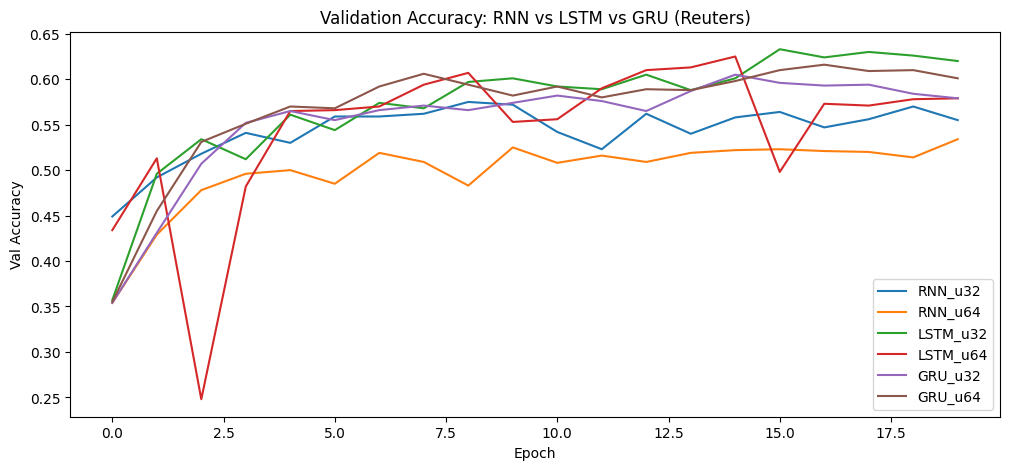

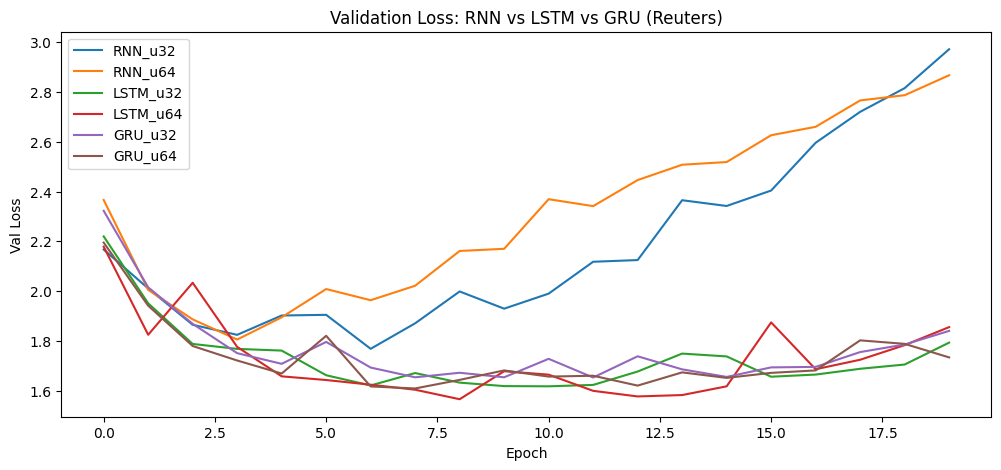

In [5]:
# Plot Validation Accuracy
plt.figure(figsize=(12,5))
for name, hist in histories.items():
    plt.plot(hist.history["val_accuracy"], label=name)
plt.title("Validation Accuracy: RNN vs LSTM vs GRU (Reuters)")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12,5))
for name, hist in histories.items():
    plt.plot(hist.history["val_loss"], label=name)
plt.title("Validation Loss: RNN vs LSTM vs GRU (Reuters)")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.legend()
plt.show()